In [2]:
import gzip
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("usa_00005.csv.gz", compression="gzip")

In [4]:
new_df = df[["STATEFIP", "AGE", "EMPSTAT", "EDUC"]]

In [5]:
codebook_txt = open("usa_00005.cbk.txt", 'r')

# Load all of the lines of txt and put them into a list
# When looking at the list of all lines in another cell we can start to find the places of the indexes necessary

all_lines = []
for line in codebook_txt.readlines():
    all_lines.append(line)

# Find the indexes in all_lines for the state decoder
index_1 = all_lines.index("01\t\tAlabama\n")
index_2 = all_lines.index("56\t\tWyoming\n")

# Find the indexes in all_lines for the educational attainment decoder
index_3 = all_lines.index("00\t\tN/A or no schooling\n")
index_4 = all_lines.index("11\t\t5+ years of college\n")

# Find the indexes in all_lines for the employment status decoder
index_6 = all_lines.index("3\t\tNot in labor force\n")
index_5 = index_6 - 3

In [6]:
state_decoder = {}
for line in all_lines[index_1:index_2+1]:
    line_split = line.split("\t\t")
    line_split[0] = int(line_split[0])
    line_split[1] = line_split[1][:-1]
    state_decoder[line_split[0]] = line_split[1]

In [7]:
education_decoder = {}
for line in all_lines[index_3:index_4+1]:
    line_split = line.split("\t\t")
    line_split[0] = int(line_split[0])
    line_split[1] = line_split[1][:-1]
    education_decoder[line_split[0]] = line_split[1]

In [8]:
employment_decoder = {}
for line in all_lines[index_5:index_6+1]:
    line_split = line.split("\t\t")
    line_split[0] = int(line_split[0])
    line_split[1] = line_split[1][:-1]
    employment_decoder[line_split[0]] = line_split[1]

In [9]:
# Apply the three maps to replace the values in the dataframe
new_df["STATEFIP"].replace(state_decoder, inplace = True) 
new_df["EDUC"].replace(education_decoder, inplace = True)
new_df["EMPSTAT"].replace(employment_decoder, inplace = True)

/Users/oliviereverts/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [10]:
# Filter for individuals who are older than 25
age_18 = new_df[new_df.AGE > 17]

In [11]:
# Create a map that will create two groups for education: those who have attended at least one year of college
# and those who have not

education_list = age_18["EDUC"].unique()

some_college_map = {}

for i in education_list:
    if "college" in i:
        some_college_map[i] = "Some college"
    else:
        some_college_map[i] = "No college"

In [12]:
# Create the two groups based on the map on the pandas dataframe 

age_18["EDUC"].replace(some_college_map, inplace = True)

In [13]:
def get_proportions_of_series(pd_series):
    proportion_counts = pd_series.value_counts(normalize=True)
    proportions_dictionary = proportion_counts.to_dict()
    return proportions_dictionary

In [14]:
state_list = age_18["STATEFIP"].unique()

column_names = ["State", 
                 "Proportion Some College", 
                 "Proportion No College", 
                 "Proportion Not In Labor Force",
                 "Proportion Employed",
                 "Proportion Unemployed"]

new_ipums_df = pd.DataFrame(columns = column_names)

for state in state_list:
    
    prop_df = age_18[age_18.STATEFIP == state]
    college_proportions = get_proportions_of_series(prop_df["EDUC"])
    employment_proportions = get_proportions_of_series(prop_df["EMPSTAT"])
    
    state_proportions_dictionary = {}
    
    state_proportions_dictionary["State"] = state
    state_proportions_dictionary["Proportion Some College"] = college_proportions["Some college"]
    state_proportions_dictionary["Proportion No College"] = college_proportions["No college"]
    state_proportions_dictionary["Proportion Not In Labor Force"] = employment_proportions["Not in labor force"]
    state_proportions_dictionary["Proportion Employed"] = employment_proportions["Employed"]
    state_proportions_dictionary["Proportion Unemployed"] = employment_proportions["Unemployed"]
    
    new_ipums_df = new_ipums_df.append(state_proportions_dictionary, ignore_index=True)

In [ ]:
percent_df = new_ipums_df.copy()
percent_df["Proportion Unemployed"] = 100*percent_df["Proportion Unemployed"]
percent_df["Proportion Employed"] = 100*percent_df["Proportion Employed"]
percent_df["Proportion Some College"] = 100*percent_df["Proportion Some College"]
percent_df["Proportion No College"] = 100*percent_df["Proportion No College"]
percent_df["Proportion Not In Labor Force"] = 100*percent_df["Proportion Not In Labor Force"]

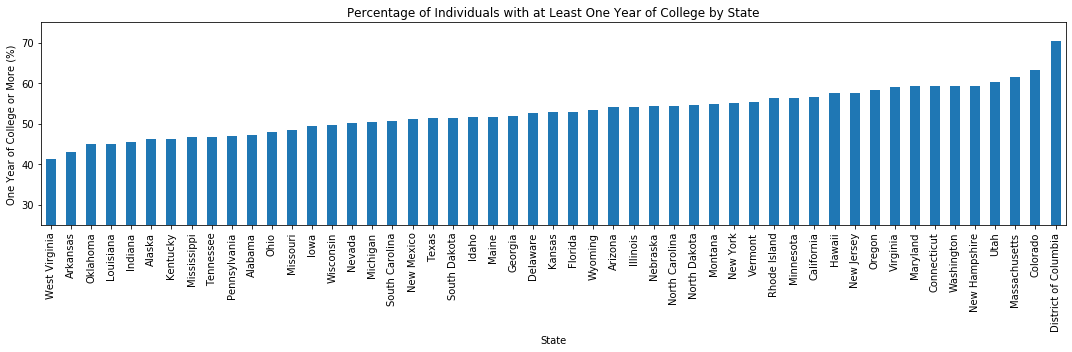

In [30]:
percent_df.sort_values("Proportion Some College").plot(kind = 'bar', x="State", y="Proportion Some College", 
                                                                  figsize=(15,5), legend = False, 
                                                                  ylim = (25, 75), 
                                                                  title = "Percentage of Individuals with at Least One Year of College by State")
plt.xlabel("State")
plt.ylabel("One Year of College or More (%)")
plt.tight_layout()
plt.savefig("Educational_Attainment_by_State.png")

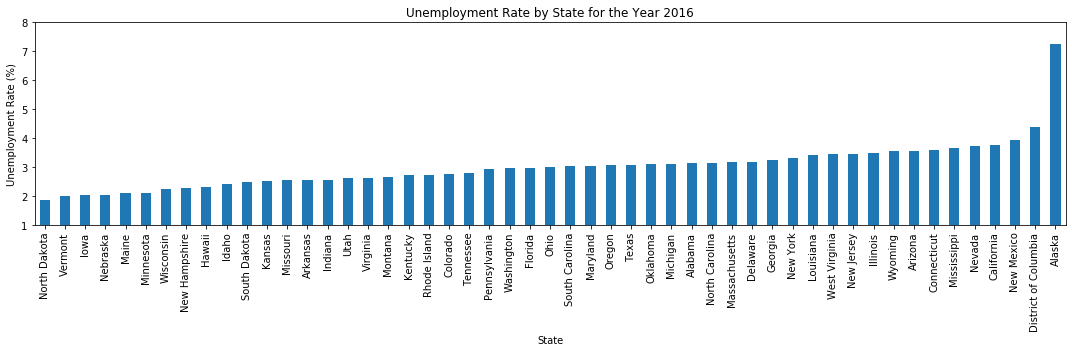

In [29]:
percent_df.sort_values("Proportion Unemployed").plot(kind = 'bar', x="State", y="Proportion Unemployed", 
                                                                figsize=(15,5), legend = False, 
                                                                ylim = (1, 8), 
                                                                title = "Unemployment Rate by State for the Year 2016")
plt.xlabel("State")
plt.ylabel("Unemployment Rate (%)")
plt.tight_layout()
plt.savefig("Unemployment_Rate_by_State.png")

In [21]:
new_ipums_df.to_csv("IPUMS_proportions.csv")

In [22]:
new_ipums_df["Proportion Some College"].describe()

count    51.000000
mean      0.529032
std       0.057071
min       0.413158
25%       0.488307
50%       0.529085
75%       0.564580
max       0.704529
Name: Proportion Some College, dtype: float64

In [23]:
new_ipums_df["Proportion Unemployed"].describe()

count    51.000000
mean      0.030110
std       0.008251
min       0.018705
25%       0.025494
50%       0.029968
75%       0.033582
max       0.072455
Name: Proportion Unemployed, dtype: float64

In [16]:
new_ipums_df

,State,Proportion Some College,Proportion No College,Proportion Not In Labor Force,Proportion Employed,Proportion Unemployed
0,Alabama,0.471151,0.528849,0.457263,0.511351,0.031386
1,Alaska,0.462052,0.537948,0.341226,0.586319,0.072455
2,Arizona,0.541059,0.458941,0.433157,0.531268,0.035575
3,Arkansas,0.429179,0.570821,0.451082,0.523278,0.025640
4,California,0.565081,0.434919,0.380681,0.581727,0.037591
5,Colorado,0.632397,0.367603,0.341994,0.630582,0.027425
6,Connecticut,0.593241,0.406759,0.353512,0.610656,0.035832
7,Delaware,0.525653,0.474347,0.406622,0.561500,0.031879
8,District of Columbia,0.704529,0.295471,0.310510,0.645789,0.043701
9,Florida,0.529875,0.470125,0.443865,0.526423,0.029711
